In [27]:
import numpy as np
from catboost import CatBoostRegressor
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import matplotlib.pyplot as plt

In [28]:
# Загрузка данных
train_df = pd.read_excel("data/excel/train.xlsx")
test_df = pd.read_excel("data/excel/test.xlsx")

# логирование
print(f'Размер тренировочной выборки: {train_df.shape}')
print(f'Размер тестовой выборки: {test_df.shape}')

Размер тренировочной выборки: (400, 2)
Размер тестовой выборки: (28, 2)


In [29]:
train_df['dt'] = pd.to_datetime(train_df['dt'], dayfirst=True)
test_df['dt'] = pd.to_datetime(test_df['dt'], dayfirst=True)

In [30]:
# Переименовываем колонку с ценой
train_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')
test_df.rename(columns={'Цена на арматуру': 'Price'}, inplace=True, errors='ignore')

In [31]:
# Объединение данных
combined_df = pd.concat([train_df[['dt', 'Price']], test_df[['dt', 'Price']]]).reset_index(drop=True)
# логирование
print(f'Размер объединенного датасета: {combined_df.shape}')

combined_df = combined_df.set_index('dt', drop=True)

Размер объединенного датасета: (428, 2)


In [32]:
X = combined_df.drop(columns=['Price']).iloc[:-1, :]
y = combined_df['Price'].values[1:]
X['Price_source'] = combined_df['Price'].values[:-1]
y = y[1:]
X = X.iloc[1:, :]

In [33]:
# Разделение данных
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

In [34]:
# Логарифмирование целевой переменной
y_train_log, y_test_log = np.log1p(y_train), np.log1p(y_test)

In [35]:
# Кросс-валидация
tscv = TimeSeriesSplit(n_splits=3)

In [36]:
# Параметры модели
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.02,
    depth=5,
    loss_function='MAE',
    early_stopping_rounds=100,
    has_time=True,                    # Учитываем временную зависимость
)
# Обучение модели
model.fit(X_train, y_train_log, eval_set=(X_test, y_test_log))

0:	learn: 0.1819284	test: 0.4579636	best: 0.4579636 (0)	total: 709us	remaining: 708ms
1:	learn: 0.1785609	test: 0.4509778	best: 0.4509778 (1)	total: 1.2ms	remaining: 601ms
2:	learn: 0.1751568	test: 0.4435781	best: 0.4435781 (2)	total: 1.56ms	remaining: 518ms
3:	learn: 0.1719098	test: 0.4351383	best: 0.4351383 (3)	total: 1.9ms	remaining: 474ms
4:	learn: 0.1691489	test: 0.4295873	best: 0.4295873 (4)	total: 2.23ms	remaining: 444ms
5:	learn: 0.1659252	test: 0.4220666	best: 0.4220666 (5)	total: 2.58ms	remaining: 427ms
6:	learn: 0.1633852	test: 0.4143121	best: 0.4143121 (6)	total: 2.91ms	remaining: 413ms
7:	learn: 0.1602147	test: 0.4058024	best: 0.4058024 (7)	total: 3.25ms	remaining: 403ms
8:	learn: 0.1577298	test: 0.4024550	best: 0.4024550 (8)	total: 3.57ms	remaining: 393ms
9:	learn: 0.1546067	test: 0.3939651	best: 0.3939651 (9)	total: 3.89ms	remaining: 386ms
10:	learn: 0.1525095	test: 0.3912845	best: 0.3912845 (10)	total: 4.23ms	remaining: 380ms
11:	learn: 0.1501253	test: 0.3838355	best: 0

In [37]:
mae_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='neg_mean_absolute_error')
r2_scores = cross_val_score(model, X_train, y_train_log, cv=tscv, scoring='r2')

0:	learn: 0.1399990	total: 233us	remaining: 233ms
1:	learn: 0.1376191	total: 468us	remaining: 234ms
2:	learn: 0.1353475	total: 607us	remaining: 202ms
3:	learn: 0.1330359	total: 720us	remaining: 180ms
4:	learn: 0.1305420	total: 856us	remaining: 170ms
5:	learn: 0.1283297	total: 970us	remaining: 161ms
6:	learn: 0.1262580	total: 1.09ms	remaining: 154ms
7:	learn: 0.1244411	total: 1.13ms	remaining: 140ms
8:	learn: 0.1224534	total: 1.29ms	remaining: 142ms
9:	learn: 0.1206384	total: 1.38ms	remaining: 137ms
10:	learn: 0.1183254	total: 1.51ms	remaining: 136ms
11:	learn: 0.1160048	total: 1.66ms	remaining: 136ms
12:	learn: 0.1140972	total: 1.78ms	remaining: 135ms
13:	learn: 0.1119273	total: 1.91ms	remaining: 134ms
14:	learn: 0.1100064	total: 2.05ms	remaining: 134ms
15:	learn: 0.1082708	total: 2.18ms	remaining: 134ms
16:	learn: 0.1066322	total: 2.34ms	remaining: 135ms
17:	learn: 0.1047343	total: 2.65ms	remaining: 145ms
18:	learn: 0.1032197	total: 2.85ms	remaining: 147ms
19:	learn: 0.1015965	total: 

112:	learn: 0.0294154	total: 22.5ms	remaining: 177ms
113:	learn: 0.0292929	total: 22.6ms	remaining: 176ms
114:	learn: 0.0291464	total: 22.8ms	remaining: 176ms
115:	learn: 0.0289807	total: 23ms	remaining: 175ms
116:	learn: 0.0287556	total: 23.2ms	remaining: 175ms
117:	learn: 0.0285372	total: 23.4ms	remaining: 175ms
118:	learn: 0.0282330	total: 23.5ms	remaining: 174ms
119:	learn: 0.0280250	total: 23.7ms	remaining: 174ms
120:	learn: 0.0278074	total: 23.8ms	remaining: 173ms
121:	learn: 0.0276784	total: 24ms	remaining: 173ms
122:	learn: 0.0274565	total: 24.2ms	remaining: 172ms
123:	learn: 0.0272763	total: 24.4ms	remaining: 172ms
124:	learn: 0.0270671	total: 24.5ms	remaining: 172ms
125:	learn: 0.0269373	total: 24.7ms	remaining: 171ms
126:	learn: 0.0267395	total: 24.8ms	remaining: 171ms
127:	learn: 0.0265582	total: 25ms	remaining: 170ms
128:	learn: 0.0263838	total: 25.2ms	remaining: 170ms
129:	learn: 0.0262879	total: 25.3ms	remaining: 170ms
130:	learn: 0.0261441	total: 25.5ms	remaining: 169ms

In [38]:
# Предсказание
preds = np.expm1(model.predict(X_test))

# Метрики
print(f"R²: {r2_score(y_test, preds):.4f}")
print(f"MAE: {mean_absolute_error(y_test, preds):.4f}")
print(f"MSE: {mean_squared_error(y_test, preds):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.4f}")
print(f"Средний MAE на кросс-валидации: {-mae_scores.mean():.4f}")
print(f"Средний R² на кросс-валидации: {r2_scores.mean():.4f}")

R²: 0.9336
MAE: 2155.2933
MSE: 8706932.6960
RMSE: 2950.7512
Средний MAE на кросс-валидации: 0.0541
Средний R² на кросс-валидации: 0.7497


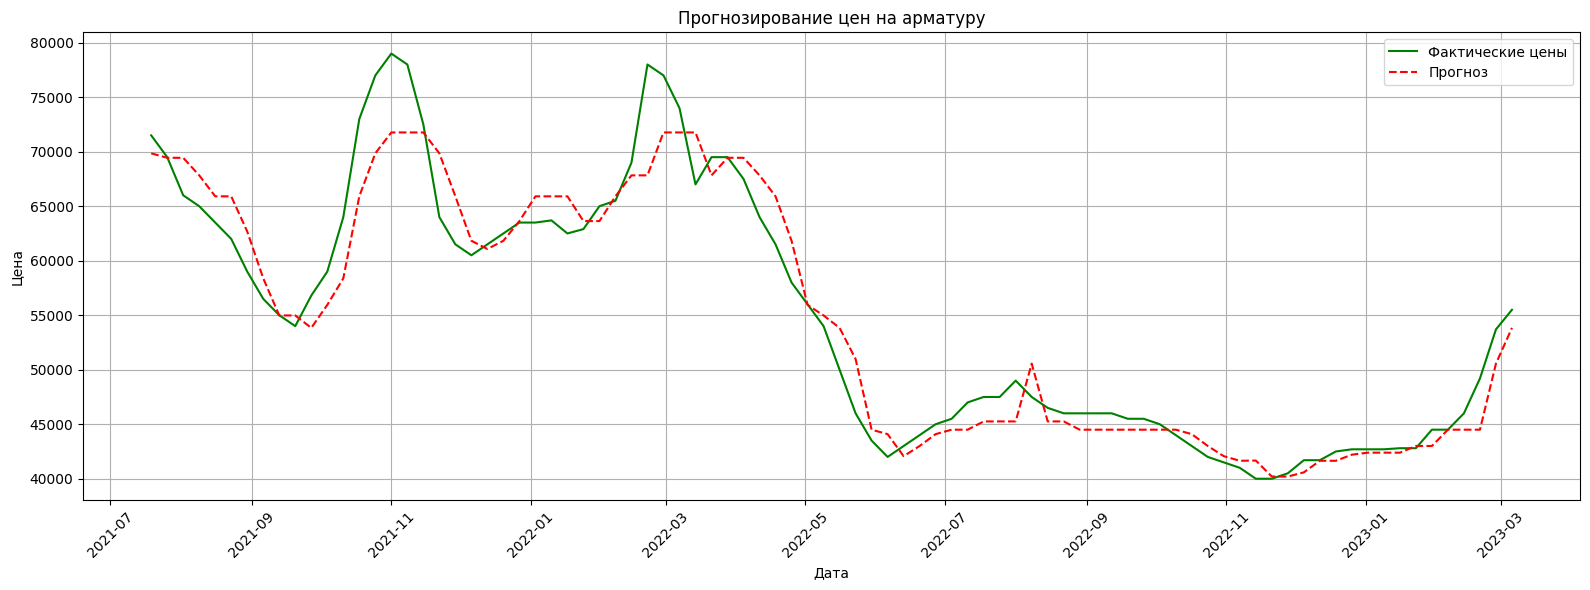

In [39]:
# Визуализация
plt.figure(figsize=(16, 6))
plt.plot(X_test.index, y_test, label='Фактические цены', color='green')
plt.plot(X_test.index, preds, label='Прогноз', color='red', linestyle='--')
plt.title('Прогнозирование цен на арматуру')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Сохранение модели
model.save_model("catboostmodel.cbm")